# Docstrum

### Set-up

In [154]:
import cv2
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

### Pre-processing

Here I implemented a simple binarization procedure (otsu's thresholding). 

The implementation of the $k$-fill filter proposed in the paper is not yet implemented. 

Instead, I'm just removing small connected components.

In [155]:
def get_binary_image(img):
    thresh = skfilters.threshold_otsu(img)
    return img < thresh

def remove_small_components(binary_image, k):
    """
    Remove connected components smaller than a given size.

    Args:
        binary_image (numpy.ndarray): Binary image (1 for foreground, 0 for background).
        k (int): Minimum size of connected components to retain.

    Returns:
        numpy.ndarray: Binary image with small components removed.
    """
    # Label connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    
    # Create an output image initialized to 0
    output_image = np.zeros_like(binary_image, dtype=np.uint8)
    
    # Iterate over each component
    for i in range(1, num_labels):  # Skip the background label (0)
        if stats[i, cv2.CC_STAT_AREA] >= k:
            # Retain components larger than or equal to k
            output_image[labels == i] = 1
    
    return output_image

In [156]:
binary_image = cv2.imread('input_2.png', cv2.IMREAD_GRAYSCALE)
_, binary_image = cv2.threshold(binary_image, 128, 255, cv2.THRESH_BINARY)
binary_image = (binary_image == 0).astype(np.uint8)  # Invert binary image (1 for text, 0 for background)
binary_image = remove_small_components(binary_image, 15)

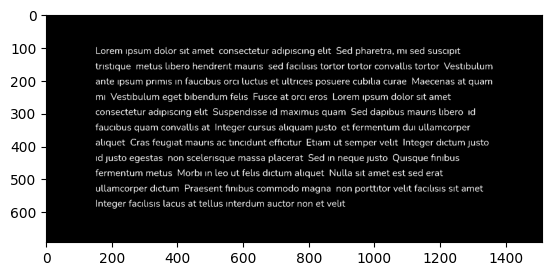

In [157]:
plt.imshow(binary_image, cmap='gray')

### Extract components centroids

In [158]:
def extract_text_centroids(binary_image):
    """
    Extract centroids of connected components in a binary image.
    
    Args:
        binary_image (numpy.ndarray): Binary image of the document (1 for text, 0 for background).
        
    Returns:
        list of tuples: List of (x, y) coordinates of centroids.
    """
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)
    
    # Exclude background (label 0)
    text_centroids = [(int(c[0]), int(c[1])) for i, c in enumerate(centroids) if i != 0]
    
    return text_centroids


def plot_text_centroids(binary_image, centroids, save = False):
    """
    Plots the text centroids on top of the binary image.
    
    Args:
        binary_image (numpy.ndarray): Binary image of the document (1 for text, 0 for background).
        centroids (list of tuples): List of (x, y) coordinates of text centroids.
    """
    # Create a color image to overlay centroids
    binary_color = cv2.cvtColor(((1-binary_image) * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    
    # Overlay centroids
    for (x, y) in centroids:
        cv2.circle(binary_color, (x, y), radius=3, color=(255, 0, 0), thickness=-1)  # Red circles
    if save:
        cv2.imwrite("centroids.png", binary_color)
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_color)
    plt.title("Text Centroids Overlay")
    plt.axis("off")
    plt.show()

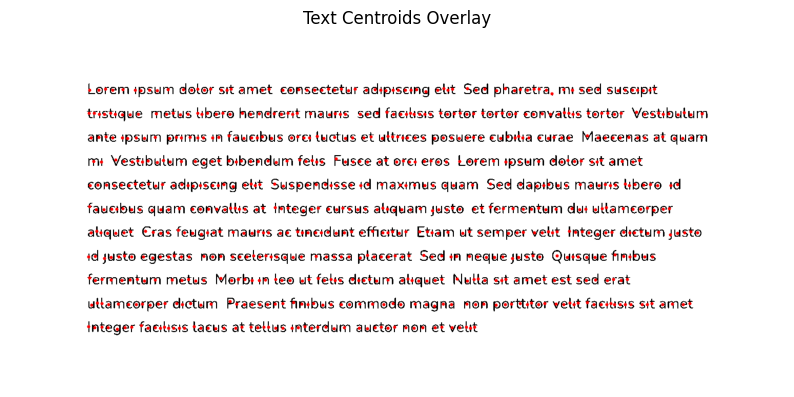

In [159]:
centroids = extract_text_centroids(binary_image)
plot_text_centroids(binary_image, centroids)

### Find $k$ nearest neighbors, their distances and their angles

Here we shall set $k=5$ as suggested by the paper (still, this is a parameter we can play with).

In [160]:
from scipy.spatial import KDTree
import math

def find_k_nearest_neighbors(centroids, k):
    """
    Find the k-nearest neighbors for each centroid and their corresponding distances and angles.

    Args:
        centroids (list of tuples): List of (x, y) coordinates of centroids.
        k (int): Number of nearest neighbors to find.

    Returns:
        neighbor_indices: A dictionary where keys are centroid indices and values are lists of the indices
          of its k-nearest neighbors.
        neighbor_distances: A dictionary where keys are centroid indices and values are lists of the distances
          to its k-nearest neighbors.
        neighbor_indices: A dictionary where keys are centroid indices and values are lists of the angles
          to its k-nearest neighbors.
    """
    if len(centroids) < k + 1:
        raise ValueError("Number of centroids must be greater than k.")
    
    # Convert centroids to numpy array
    centroids_array = np.array(centroids)
    
    # Build a KDTree for efficient nearest neighbor search
    tree = KDTree(centroids_array)
    
    # Find k+1 neighbors for each centroid (include the point itself)
    distances, indices = tree.query(centroids_array, k=k+1)  # query returns (distances, indices)
    
    # Initialize dictionaries
    neighbor_indices = {}
    neighbor_distances = {}
    neighbor_angles = {}
    
    # Extract the neighbor indices (skip the first as it's the point itself)
    for i in range(len(centroids)):
        indices_list = []
        distances_list = []
        angles_list = []
        for j in range(1, k+1):  # Skip the first one as it's the point itself
            neighbor_idx = indices[i][j]
            dist = distances[i][j]
            # Calculate angle between centroid[i] and centroid[neighbor_idx]
            x1, y1 = centroids[i]
            x2, y2 = centroids[neighbor_idx]
            if -math.pi/2 <= np.arctan2(y2 - y1, x2 - x1) and np.arctan2(y2 - y1, x2 - x1) < math.pi/2:
                angle = np.arctan2(y2 - y1, x2 - x1)
            else: 
                angle = np.arctan2(y1 - y2, x1 - x2)
            
            # Append the values to the respective lists
            indices_list.append(neighbor_idx)
            distances_list.append(dist)
            angles_list.append(np.rad2deg(angle)) # Convert to degrees
        
        # Store in dictionaries indexed by the position of the centroid
        neighbor_indices[i] = indices_list
        neighbor_distances[i] = distances_list
        neighbor_angles[i] = angles_list
    
    return neighbor_indices, neighbor_distances, neighbor_angles


def plot_neighbours(binary_image, centroids, neighbors, point):
    """
    Plots the k-nearest neighbors of point on top of the binary image.
    
    Args:
        binary_image (numpy.ndarray): Binary image of the document (1 for text, 0 for background).
        centroids (list of tuples): List of (x, y) coordinates of text centroids.
        neighbors: dict where keys are centroid indices and values are lists of the indices
          of its k-nearest neighbors.
        point: centroid index to plot its k-nearest neighbors
    """
    # Create a color image to overlay centroids
    binary_color = cv2.cvtColor((binary_image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    
    # Overlay centroids
    for pos in neighbors[point]:
        (x, y) = centroids[pos]
        cv2.circle(binary_color, (x, y), radius=3, color=(255, 0, 0), thickness=-1)  # Red circles
    (x, y) = centroids[point]
    cv2.circle(binary_color, (x, y), radius=3, color=(0, 0, 255), thickness=-1)  # Red circle
    
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_color)
    plt.title("Example of a centroid and its nearest neighbors")
    plt.axis("off")
    plt.show()


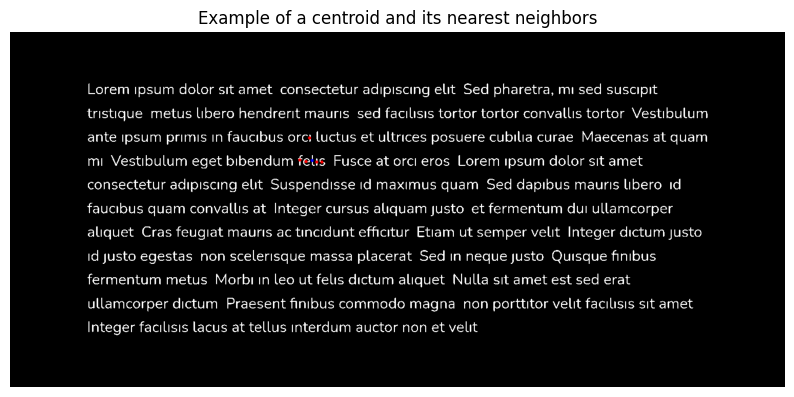

In [161]:
neighbors, distances, angles = find_k_nearest_neighbors(centroids, 5)
plot_neighbours(binary_image, centroids, neighbors, point=240)

### Build docstrum

In [162]:
def plot_docstrum(centroids, k, neighbor_indices):
    """
    Plot the relative position of neighbors to each centroid in the plane.
    Each centroid is translated to (0, 0), and its neighbors are plotted accordingly.

    Args:
        centroids (list of tuples): List of (x, y) coordinates of centroids.
        k (int): Number of nearest neighbors to plot for each centroid.
        neighbor_indices (dict): Dictionary where keys are centroid indices, and values are lists of k nearest neighbors' indices.
    """
    
    # Initialize list to hold plot data
    plot_points = []
    
    for i in range(len(centroids)):
        centroid = centroids[i]

        # For each neighbor, translate it and store the data
        for neighbor_idx in neighbor_indices[i]:
            neighbor = centroids[neighbor_idx]
            translated_neighbor = np.array([neighbor[0] - centroid[0], neighbor[1] - centroid[1]])
            plot_points.append(translated_neighbor)
    
    # Convert plot_points and plot_lines to numpy arrays for faster plotting
    plot_points = np.array(plot_points)
    
    # Create the plot
    plt.figure(figsize=(8, 8))

    # Plot the neighbors (blue circles)
    plt.scatter(plot_points[1:, 0], plot_points[1:, 1], color='blue', marker='o')
    
    # Set axes properties
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('Relative X')
    plt.ylabel('Relative Y')
    plt.title('Relative Positions of Neighbors to Each Centroid')
    plt.grid(True)
    plt.show()

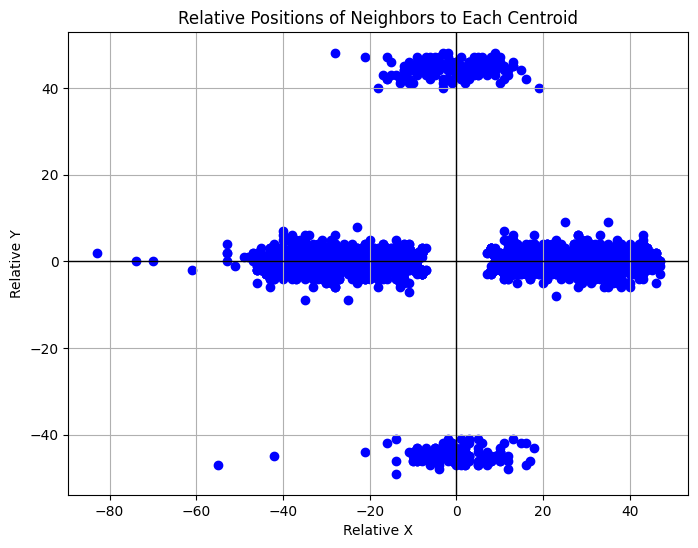

In [163]:
plot_docstrum(centroids, 5, neighbors)

### Plot angles histogram and find main orientation

Circular smoothing of the histogram is still to be implemented.

A somehow hidden parameter is the resolution (number of bins) in the histogram (need to check).

In [164]:
def plot_angle_histogram(neighbor_angles):
    """
    Plot a histogram of the angles in the neighbor_angles dictionary.

    Args:
        neighbor_angles (dict): A dictionary where keys are centroid indices, 
                                 and values are lists of angles for the k nearest neighbors.
    """
    # Extract all the angles into a single list
    angles = [angle for angles_list in neighbor_angles.values() for angle in angles_list]
    
    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(angles, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
    
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Neighbor Angles')
    plt.grid(True)
    plt.show()

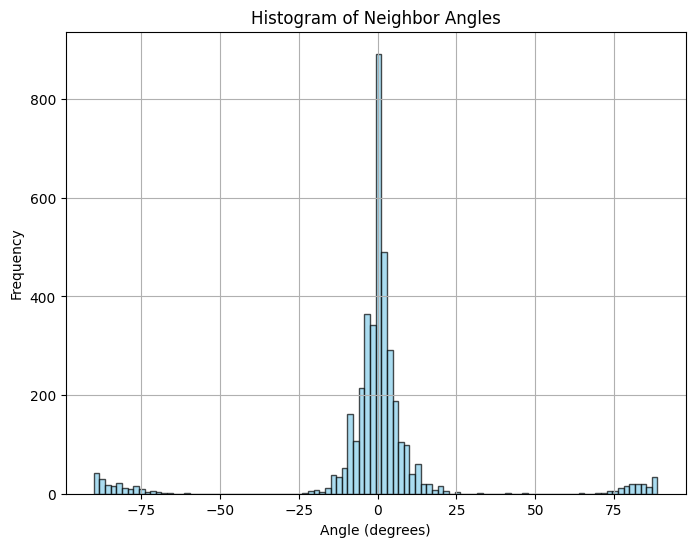

In [165]:
plot_angle_histogram(angles)

In [166]:
def find_peak_angle(neighbor_angles):
    """
    Find the peak angle in the neighbor_angles dictionary.

    Args:
        neighbor_angles (dict): A dictionary where keys are centroid indices, 
                                 and values are lists of angles for the k nearest neighbors.

    Returns:
        float: The peak angle (mode) of the angle distribution.
    """
    # Extract all the angles into a single list
    angles = [angle for angles_list in neighbor_angles.values() for angle in angles_list]
    
    # Compute the histogram
    hist, bin_edges = np.histogram(angles, bins=100)
    
    # Find the index of the peak (max frequency)
    peak_index = np.argmax(hist)
    
    # Find the bin center of the peak
    peak_angle = (bin_edges[peak_index] + bin_edges[peak_index + 1]) / 2
    
    return peak_angle


In [167]:
p = find_peak_angle(angles)
print(f"Main orientation is {p} degrees")

Main orientation is 0.28446800625869884 degrees


### Histograms of distances and inter-character and inter-line spacing estimation

To estimate the inter-character distance we compute the peak of the histogram of distances for the neighbors whose angles are coherent with the main orientation ([peak - margin, peak + margin]).

To estimate the inter-line distance we compute the peak of the histogram of distances for the neighbors whose angles are perpendicular with the main orientation ([peak + 90 - margin, peak + 90 + margin]).

I'm setting this margin parameter by hand.

Again, I didn't implement any smoothing.

In [168]:
def histogram_of_filtered_distances(neighbor_angles, neighbor_distances, peak_angle, margin):
    """
    Plot a histogram of distances for the neighbors whose angles are within the range [peak - margin, peak + margin].

    Args:
        neighbor_angles (dict): A dictionary where keys are centroid indices, 
                                 and values are lists of angles for the k nearest neighbors.
        neighbor_distances (dict): A dictionary where keys are centroid indices, 
                                   and values are lists of distances for the k nearest neighbors.
        peak_angle (float): The peak angle (mode) of the angle distribution.
        margin (float): The margin for filtering neighbors by angle.

    Returns:
        None
    """
    # Collect distances for neighbors within the angle range
    filtered_distances = []
    
    for centroid, angles in neighbor_angles.items():
        distances = neighbor_distances[centroid]
        for i, angle in enumerate(angles):
            # Check if the angle is within the range [peak - margin, peak + margin]
            if peak_angle - margin <= angle <= peak_angle + margin:
                filtered_distances.append(distances[i])

    # Plot the histogram of the filtered distances
    plt.figure(figsize=(8, 6))
    plt.hist(filtered_distances, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title(f'Distances of neighbors oriented between [{peak_angle - margin}, {peak_angle + margin}]')
    plt.grid(True)
    plt.show()

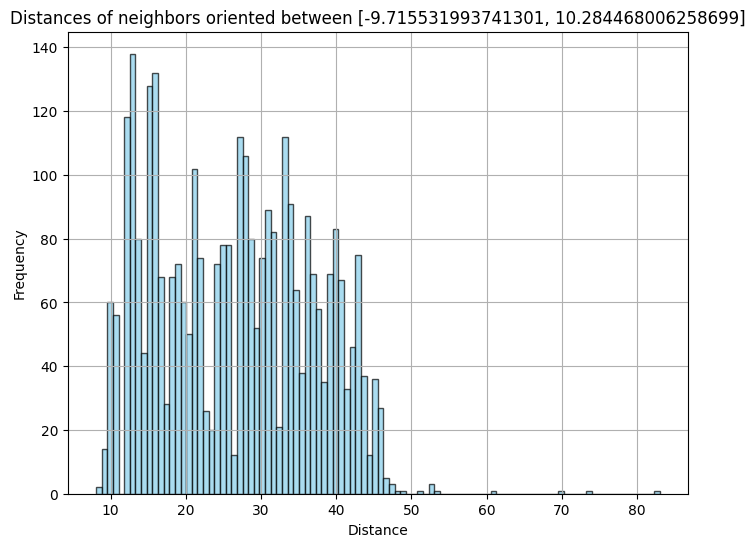

In [169]:
histogram_of_filtered_distances(angles, distances, p, 10)

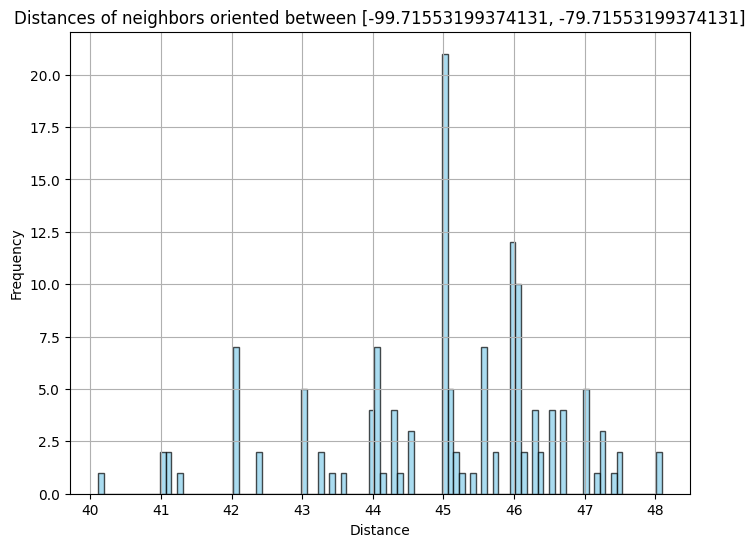

In [170]:
histogram_of_filtered_distances(angles, distances, p-90, 10)

In [171]:
def find_peak_within_angle(neighbor_distances, neighbor_angles, angle, margin):
    """
    Find the peak distance in the neighbor_distances for the neighbors whose angles are within the range [angle - margin, angle + margin]

    Args:
        neighbor_distances (dict): A dictionary where keys are centroid indices, 
                                 and values are lists of distances for the k nearest neighbors.

    Returns:
        float: The peak distance (mode) of the distances distribution.
    """
    # Collect distances for neighbors within the angle range
    filtered_distances = []
    
    for centroid, angles in neighbor_angles.items():
        distances = neighbor_distances[centroid]
        for i, a in enumerate(angles):
            # Check if the angle is within the range [peak - margin, peak + margin]
            if angle - margin <= a <= angle + margin:
                filtered_distances.append(distances[i])

    # Compute the histogram
    hist, bin_edges = np.histogram(filtered_distances, bins=100)
    
    # Find the index of the peak (max frequency)
    peak_index = np.argmax(hist)
    
    # Find the bin center of the peak
    peak_dist = (bin_edges[peak_index] + bin_edges[peak_index + 1]) / 2
    
    return peak_dist

In [172]:
within_line_dist = find_peak_within_angle(distances, angles, p, 10)
print(f'Within-line spacing: {within_line_dist}')
inter_line_dist = find_peak_within_angle(distances, angles, p-90, 10)
print(f'Inter-line spacing: {inter_line_dist}')

Within-line spacing: 12.934777032427977
Inter-line spacing: 45.0208518172725


### Transitive closure

Transitive closure on within-line nearest-neighbor pairings to obtain nearest-neighbor groups on the same text lines.

Again, there's a margin to define the angle range I'm setting by hand.

In [173]:
from collections import defaultdict, deque

def transitive_closure(neighbors, angles, angle_range):
    """
    Find equivalence classes based on the relation defined by neighbors and angles.

    Parameters:
        neighbors (dict): A dictionary where keys are indices and values are lists of nearest neighbors.
        angles (dict): A dictionary where keys are indices and values are lists of angles corresponding to the neighbors.
        angle_range (tuple): A tuple (min_angle, max_angle) specifying the range of valid angles.

    Returns:
        list: A list of equivalence classes, where each class is a set of indices.
    """
    min_angle, max_angle = angle_range

    # Build a graph where edges exist if the angle condition is satisfied
    graph = defaultdict(list)
    for key, neighbor_list in neighbors.items():
        for i, neighbor in enumerate(neighbor_list):
            if min_angle <= angles[key][i] <= max_angle:
                graph[key].append(neighbor)
                graph[neighbor].append(key)  # Ensure bidirectional connection

    # Find connected components (equivalence classes)
    visited = set()
    equivalence_classes = []

    def bfs(start):
        queue = deque([start])
        component = set()
        while queue:
            node = queue.popleft()
            if node not in visited:
                visited.add(node)
                component.add(node)
                queue.extend(graph[node])
        return component

    for node in neighbors:
        if node not in visited:
            equivalence_classes.append(bfs(node))

    return equivalence_classes

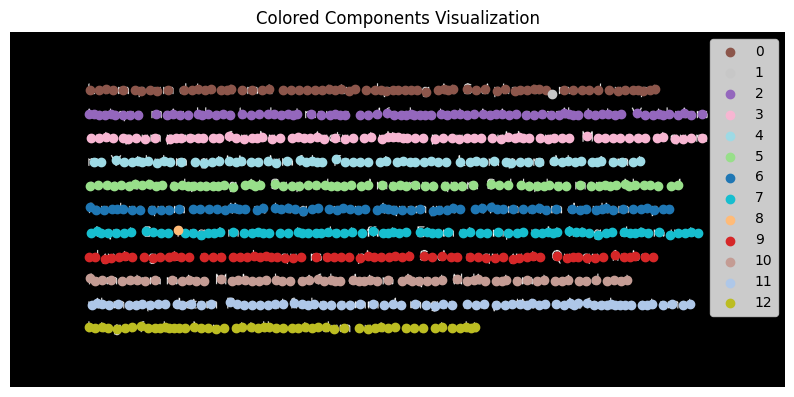

In [175]:
components = transitive_closure(neighbors, angles, (p-10, p+10))

# Visualize components
plt.figure(figsize=(10, 10))
plt.imshow(binary_image, cmap='gray')

colors = [plt.cm.tab20(i / (len(components) - 1)) for i in range(len(components))]

# Shuffle the colors to have more contrast in subsequent lines
import random
random.shuffle(colors)

for i in range(len(components)):
    centroids_line = [centroids[k] for k in components[i]]
    x, y = zip(*centroids_line)
    plt.scatter(x, y, color=colors[i], label=f"{i}")

plt.legend()
plt.title("Colored Components Visualization")
plt.axis("off")
plt.show()

### Fit a straight line to the centroids in each component

/tmp/ipykernel_10102/1790421502.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, poly1d_fn(x), '--k', color=colors[i], label=f"{i}")
/tmp/ipykernel_10102/1790421502.py:8: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x,y,1)
/tmp/ipykernel_10102/1790421502.py:8: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x,y,1)


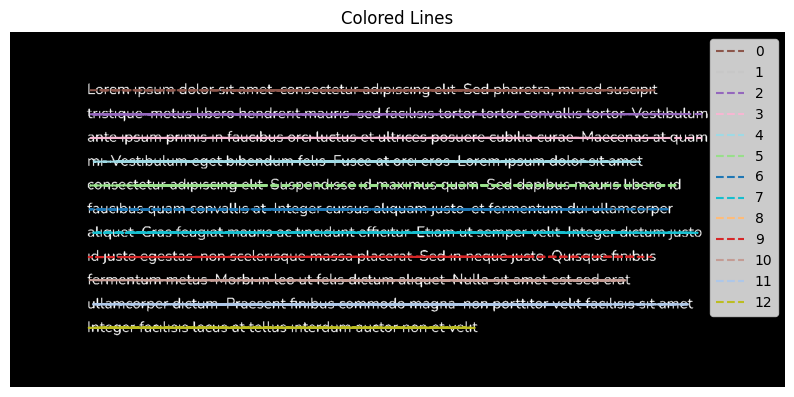

In [195]:
lines = {}

plt.figure(figsize=(10, 10))
plt.imshow(binary_image, cmap='gray')
for i in range(len(components)):
    centroids_line = [centroids[k] for k in components[i]]
    x, y = zip(*centroids_line)
    coef = np.polyfit(x,y,1)    
    poly1d_fn = np.poly1d(coef) 
    lines[i] = [(min(x), poly1d_fn(min(x))), (max(x),poly1d_fn(max(x)))] # endpoints of each segment
    plt.plot(x, poly1d_fn(x), '--k', color=colors[i], label=f"{i}") 
plt.legend()
plt.title("Colored Lines")
plt.axis("off")
plt.show()


In [196]:
lines

{0: [(155, 112.48039239795312), (1257, 112.56023452429581)],
 1: [(1057, 119.99999999999994), (1057, 119.99999999999994)],
 2: [(154, 159.43293264169512), (1350, 159.02233375041783)],
 3: [(158, 205.6018859734296), (1349, 205.64571170246433)],
 4: [(163, 251.8929749723582), (1228, 252.01671801555977)],
 5: [(156, 298.35003256044405), (1302, 298.0806933236163)],
 6: [(155, 344.8980385057254), (1286, 344.66228325241934)],
 7: [(158, 390.63426951905717), (1341, 390.6384261310932)],
 8: [(328, 385.9999999999999), (328, 385.9999999999999)],
 9: [(153, 437.93777317931847), (1253, 437.53666153969186)],
 10: [(155, 482.9057847356123), (1204, 483.3605448659282)],
 11: [(159, 530.1466437126775), (1326, 530.2814098124619)],
 12: [(153, 576.0379200120253), (906, 576.0765087529084)]}

### Structural Block Determination

In [ ]:
def angular_diference(seg_i, seg_j):
    (xOi, yOi) = seg_i[0]
    (xFi, yFi) = seg_i[1]
    (xOj, yOj) = seg_j[0]
    (xFj, yFj) = seg_j[1]
    Δxi = xFi - xOi
    Δxj = xFj - xOj
    Δyi = yFi - yOi
    Δyj = yFj - yOj
    θij = np.arctan(Δyj/Δxj) - np.arctan(Δyi/Δxi)
    θij = θij%180
    return θij

